<h3>Analysis using pySpark and Hadoop(Phase 2)</h3>

This program to replicate the analysis done in twitter_analysis.py(phase1) using pySpark and Hadoop instead of using postgresql as storage.

In this jupyter notebook file, you'll be able to see the transformation of the tweets from raw tweets to cleaned and processed tweets ready for analysis.

<h3>Reading from text file in hdfs</h3>

First we will read from the text file extracted from postgresql which contains the tweets. Then we will store it in Spark's dataframe and then convert it into Pandas dataframe. So that we can reuse our code from tweet_analysis.py which is using Pandas dataframe.

In [8]:
import findspark
findspark.init()
import pyspark # Call this only after findspark
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

#from pyspark.sql import SparkSession
import numpy as np
import pandas as pd


sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

#test sparkcontext
#print(spark)

#https://spark.apache.org/docs/latest/sql-pyspark-pandas-with-arrow.html
#entry point for spark to interact with spark's functions
sparkSession = SparkSession.builder.appName("test_read_from_pg").getOrCreate()

#path to tweets text file in hadoop hdfs
data="hdfs://namenode:9000/user/test/input/tweets_pg_export.txt"

#https://stackoverflow.com/questions/49471192/spark-2-3-0-read-text-file-with-header-option-not-working
#load text file into Spark dataframes
df_load = sparkSession.read.option("header", "true").csv(data)

#test and print 4 rows of Spark dataframe
df_load.show(4, False)

# Enable Arrow-based columnar data transfers
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

#conver Spark dataframe into Pandas dataframe
df_pandas = df_load.select("*").toPandas()

print(df_pandas)

+---------------------------------------------------------------------------------------------------------------------------------------------+
|tweet_text                                                                                                                                   |
+---------------------------------------------------------------------------------------------------------------------------------------------+
|"@flawarah ""How Haze Affects Milk Tea Brand."""                                                                                             |
|The haze are really bad                                                                                                                      |
|RT @allyxjackson: do yall understand just how bad the haze is there that they have to literally plant clouds??? cloud seeding??? 😔 and nobo…|
|RT @BRITgrlINDOfood: Standing on a bridge overlooking the Batanghari River in Jambi, Sumatra.                                           

<h3>Data Preparation</h3>

Before we start analyzing the tweets, we will perform preprocessing activities such as the below replacement rules and removing stopwords such as "the, as, in" using nltk. Nltk is a Natural language processing text processing library to help the computer to understand and analyze human language. There are more advance text processing such as stemming, lexicon normalization and lemmetization that are available to us but we will reserve that for another project. 

In [9]:
#change tweets into lowercase
df_pandas['tweet_text'] = df_pandas['tweet_text'].str.lower()
#Removing RT retweet term
df_pandas['tweet_text'] = df_pandas['tweet_text'].str.replace('rt', '')
#Removing usernames
df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'@\w+', '', regex=True)
#Removing url links
df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'http\S+', '', regex=True)
df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'www.[^ ]+', '', regex=True)
#remove next line \n
df_pandas['tweet_text'] = df_pandas['tweet_text'].replace('\n',' ', regex=True)
#remove numbers
df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'[0-9]+', '', regex=True)
#removing special characters
df_pandas['tweet_text'] = df_pandas['tweet_text'].replace(r'[!"#$%&()*+,-./:;<=>?@[\]^_`{|}~]', '', regex=True)
# Removing tweet topic
df_pandas['tweet_text'] = df_pandas['tweet_text'].str.replace('haze', '')

print(df_pandas)

                                             tweet_text
0                           how  affects milk tea brand
1                                   the  are really bad
2       do yall understand just how bad the  is ther...
3       standing on a bridge overlooking the batangh...
4             the  is worse than when i arrived yester…
...                                                 ...
4941                                      sometime okay
4942                                pollution reduction
4943  this is still the funniest shit ever esgdjgash...
4944    the weather and the  also makes me feel thirsty
4945                                pollution reduction

[4946 rows x 1 columns]


In [10]:
#import nltk
#need to manuall download 'punkt' before using this : nltk.download('punkt')
from nltk.corpus import (stopwords)

In [11]:
stop_words_eng = stopwords.words('english')

#lamda a type of hidden function or anonymous function written in one line instead of writing a new function
#apply is used to apply the lamda function on one column
#split the tweet using space in x.split() then check for if its not a stop word then join it together again with space
#and move on to the next word of the tweet


df_pandas['tweet_text'] = df_pandas['tweet_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words_eng)]))

print(df_pandas)

                                             tweet_text
0                                affects milk tea brand
1                                            really bad
2     yall understand bad literally plant clouds clo...
3     standing bridge overlooking batanghari river j...
4                                 worse arrived yester…
...                                                 ...
4941                                      sometime okay
4942                                pollution reduction
4943             still funniest shit ever esgdjgashjdsa
4944                    weather also makes feel thirsty
4945                                pollution reduction

[4946 rows x 1 columns]


<h3>Adding sentiment score</h3>

Here, we will start to process the tweets using Textblob to obtain the sentiment score.


In [12]:
#import for Natural language Processing(NLP) sentiment analysis library
from textblob import TextBlob

#https: // stackoverflow.com / questions / 54588807 / loop - to - retrieve - sentiment - analysis - in -pandas - core - series - series
#add sentiment score into a new column in dataframe
df_pandas['sentiment'] = df_pandas.tweet_text.apply(lambda tweet_text: TextBlob(tweet_text).sentiment.polarity)

print(df_pandas)

                                             tweet_text  sentiment
0                                affects milk tea brand        0.0
1                                            really bad       -0.7
2     yall understand bad literally plant clouds clo...       -0.7
3     standing bridge overlooking batanghari river j...        0.0
4                                 worse arrived yester…       -0.4
...                                                 ...        ...
4941                                      sometime okay        0.5
4942                                pollution reduction        0.0
4943             still funniest shit ever esgdjgashjdsa       -0.2
4944                    weather also makes feel thirsty        0.0
4945                                pollution reduction        0.0

[4946 rows x 2 columns]


In [13]:
class sentimentanalysis():
    """
    to convert sentiment score generated from TextBlob library into 1,-1 or 0 based on sentiment score.
    """

    def analyse_sentiment(self, df):


        sentiment = df

        if sentiment > 0:
            return 1
        elif sentiment == 0:
            return 0
        else:
            return -1

 <h3>Converting sentiment score</h3>
 
Convert sentiment score into 1(positive) or -1(negative) or 0(neutral).

In [14]:
senti=sentimentanalysis()
#convert sentiment score into 1(positive),-1(negative) or 0(neutral)
df_pandas['sentiment'] = np.array([senti.analyse_sentiment(df_pandas) for df_pandas in df_pandas['sentiment']])

print(df_pandas)

                                             tweet_text  sentiment
0                                affects milk tea brand          0
1                                            really bad         -1
2     yall understand bad literally plant clouds clo...         -1
3     standing bridge overlooking batanghari river j...          0
4                                 worse arrived yester…         -1
...                                                 ...        ...
4941                                      sometime okay          1
4942                                pollution reduction          0
4943             still funniest shit ever esgdjgashjdsa         -1
4944                    weather also makes feel thirsty          0
4945                                pollution reduction          0

[4946 rows x 2 columns]


<h3>Data visualization</h3>

Based on the sentiment scores, we will generate word clouds and word frequency graphs. We will be able to see the most prominent words people are using and disccusing.

In [15]:
#this looks good so far :)

#for os commands
import os

#for wordcloud
from wordcloud import WordCloud#,STOPWORDS
import matplotlib.pyplot as plt

In [16]:
class wordcloud():
    """
    to generate wordcloud based on sentiment value positive, negative and both positive and negative.
    """

    def wordclouddraw(self,df_pandas,sent):


        if sent == 'positive':

            #https://cmdlinetips.com/2018/02/how-to-subset-pandas-dataframe-based-on-values-of-a-column/
            text_filtered_sentiment = df_pandas['sentiment'] == 1
            text_filtered_sentiment2 = df_pandas[text_filtered_sentiment]
            text = text_filtered_sentiment2.tweet_text.to_string(index=False, header=False)
            filename = "/HAZE_pos_tweets_spark.png"

        elif sent == 'negative':

            text_filtered_sentiment = df_pandas['sentiment'] == -1
            text_filtered_sentiment2 = df_pandas[text_filtered_sentiment]
            text = text_filtered_sentiment2.tweet_text.to_string(index=False, header=False)
            filename = "/HAZE_neg_tweets_spark.png"

        else:
            #this includes both positive and negative tweets
            text = df_pandas.tweet_text.to_string( index=False, header=False)
            filename = "/HAZE_all_tweets_spark.png"



        file = os.getcwd()

        #print(file)

        wordcloud = WordCloud(
            width = 1500,
            height = 1000,
            background_color = 'black',
            #stopwords = STOPWORDS
            stopwords=['haze']
        ).generate(text)
        #generate(' '.join(str(df['tweet_text']))
        fig = plt.figure(
            figsize = (20, 10),
            facecolor = 'k',
            edgecolor = 'k')
        plt.imshow(wordcloud, interpolation = 'bilinear')#'hermite'
        plt.axis('off')
        plt.tight_layout(pad=0)

        wcpath=file+filename

        #print(wcpath)

        wordcloud.to_file(wcpath)

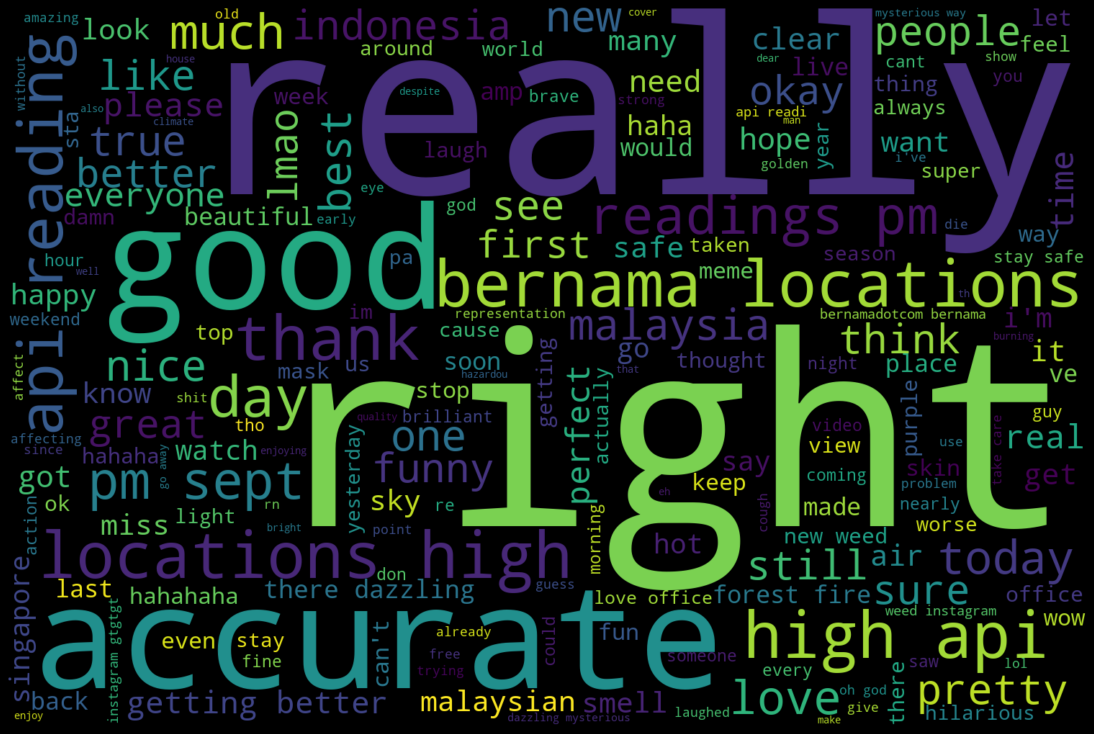

In [17]:
genwordcloud = wordcloud()

#genwordcloud.wordclouddraw(df_pandas, sent="all")
genwordcloud.wordclouddraw(df_pandas, sent="positive")


In [48]:


#print(df_pandas[df_pandas['tweet_text'].str.contains('really')  ].head(10))
#print(df_pandas[df_pandas['sentiment']==1].head(10))
#& ([df_pandas['sentiment']==1]
#print(df_pandas[(df_pandas['tweet_text']).str.contains('really')].tweet_text.head(10))

df_pos=df_pandas[df_pandas['sentiment']==1]
#print(df_pos)

#to sample "really" as a positive tweet 
print(df_pos[df_pos['tweet_text'].str.contains('really')  ].head(10))

                                            tweet_text  sentiment
176                    really feel different type heat          1
296  really affecting voice cant sing without squea...          1
384                      tf api level today cos really          1
487        oh god really took view clean air granted 😔          1
526  can't really pinpoint reason whether caused ma...          1
624                          thought twas phone really          1
703                    man really isn’t getting better          1
720           comments asean agreement really toothle…          1
877  kuar ja outdoor terus sakit kepala really give...          1
941                          thought twas phone really          1


The word "really" can't be assumed as a positive or negative word as it can be "really good" or "really bad". From the sample above, most of it are negative tweets.

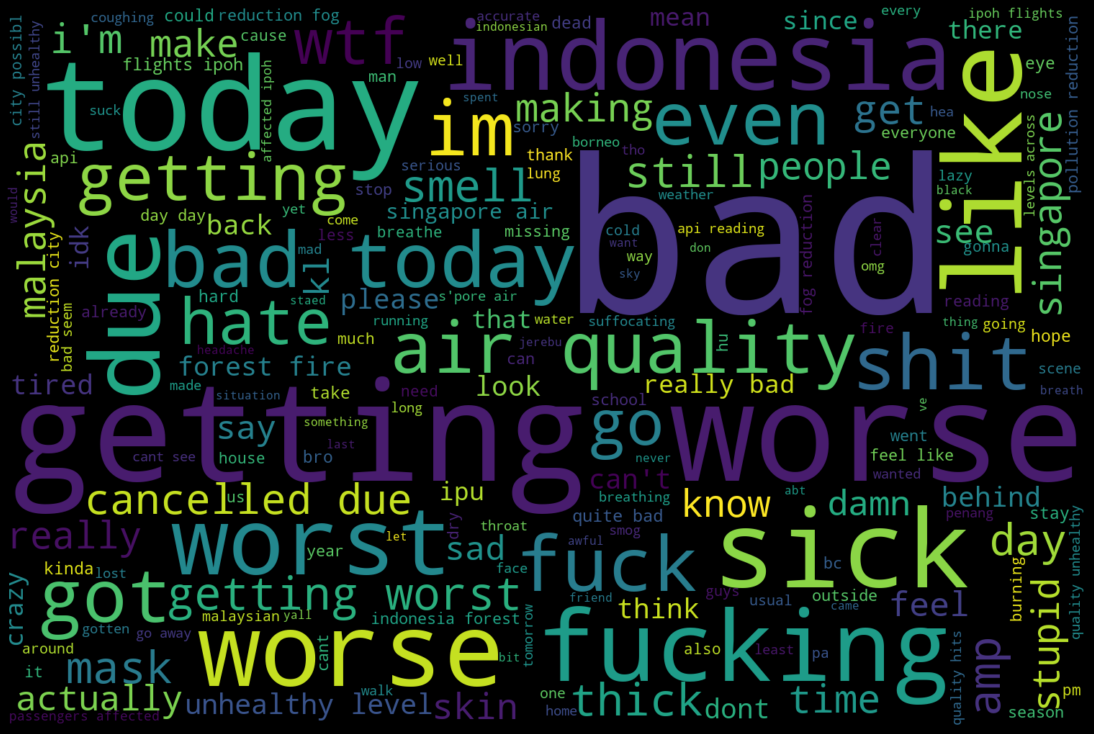

In [19]:
genwordcloud.wordclouddraw(df_pandas, sent="negative")

From the negative word cloud, it seems pretty clear that most of the words are negative. Most tweets are expressing the concern about the haze getting worse and describing how it's affecting them.

Words such as "today" and "like" doesn't seem negative by itself. In this case, it is used to describe the situation at that moment.


In [46]:
df_neg=df_pandas[df_pandas['sentiment']==-1]
#print(df_neg)

#to sample "today" as a negative tweet 
print("-------------------------\"today\"---------------------------")
print(df_neg[df_neg['tweet_text'].str.contains('today')  ].head(5))
print("-------------------------\"like\"---------------------------")
#to sample "like" as a negative tweet 
print(df_neg[df_neg['tweet_text'].str.contains('like')  ].head(5))

-------------------------"today"---------------------------
                                            tweet_text  sentiment
155  api kinda low putrajaya fact getting worse sec...         -1
188                       wah today freaking bad sia 😱         -1
226                              getting worse today 😷         -1
263  havent eaten today bcs bad cant breathe withou...         -1
322  worst today kl actually smell rancid burning s...         -1
-------------------------"like"---------------------------
                                            tweet_text  sentiment
426  skin getting really bad like wtf happening weh...         -1
428        malaysia getting worse like it’s bad 🤦🏻‍♀️😫         -1
586  feel like becoming worst even super heavy acid...         -1
598                           like crushed velvet skin         -1
637  ako ge sendan si mama ug pic sa window nya sai...         -1


In [20]:
#import sklearn
from sklearn.feature_extraction.text import (
    CountVectorizer)

import collections
import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

In [21]:
class wordfreq():

    """
    to generate a graph based on word frequency
    """

    def vectorization(self, df_pandas, sent2):
        # https://towardsdatascience.com/sentiment-analysis-with-text-mining-13dd2b33de27

        countv = CountVectorizer()
        bow = countv.fit_transform(df_pandas.tweet_text)
        word_freq = dict(zip(countv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))
        word_counter = collections.Counter(word_freq)
        word_counter_df = pd.DataFrame(word_counter.most_common(30), columns=['word', 'freq'])

        
#https://www.drawingfromdata.com/how-to-rotate-axis-labels-in-seaborn-and-matplotlib

        file = os.getcwd()
        title = "Word Frequency for %s tweets" % sent2
        fig, ax = plt.subplots(figsize=(10, 12))
        sns.barplot(x="freq", y="word", data=word_counter_df, palette="PuBuGn_d", ax=ax)

        plt.xticks(
            rotation=90,
            horizontalalignment='right',
            fontweight='light',
            #fontsize='x-large'
            size = 14
        )

        plt.xlabel("Frequency", size=14);
        plt.ylabel("30 more frequent words", size=14);

        plt.title(title, size=18)
        plt.grid(False);
        plt.gca().spines["top"].set_visible(False);
        plt.gca().spines["right"].set_visible(False);




        filename = "/HAZE_graph_%s_spark.png" %sent2
        graphpath = file + filename
        plt.savefig(graphpath, format="png")
        #plt.show()

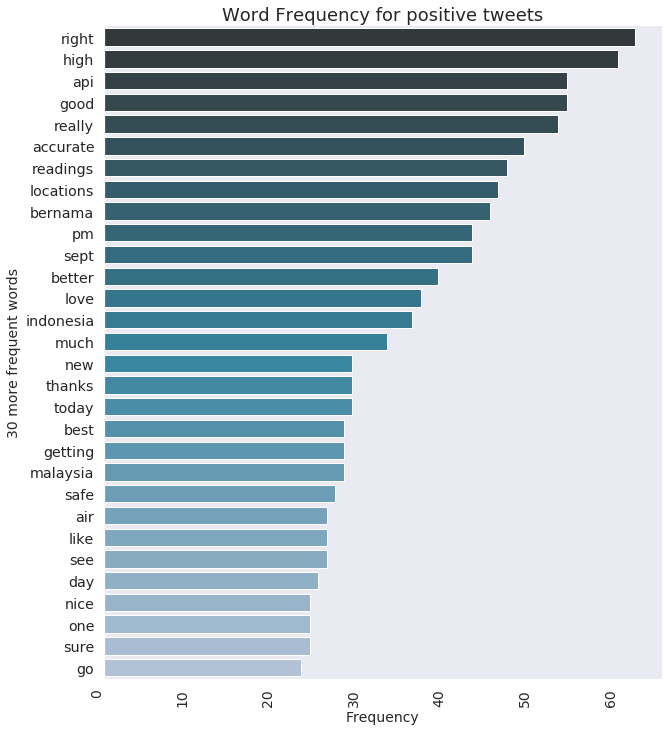

In [22]:
wf = wordfreq()

# Graph with frequency words all, positive and negative tweets and get the frequency
#wf.vectorization(df_pandas, sent2="all")
#print (df_pandas[df_pandas['sentiment'] == 1])
wf.vectorization(df_pandas[df_pandas['sentiment'] == 1], sent2="positive")


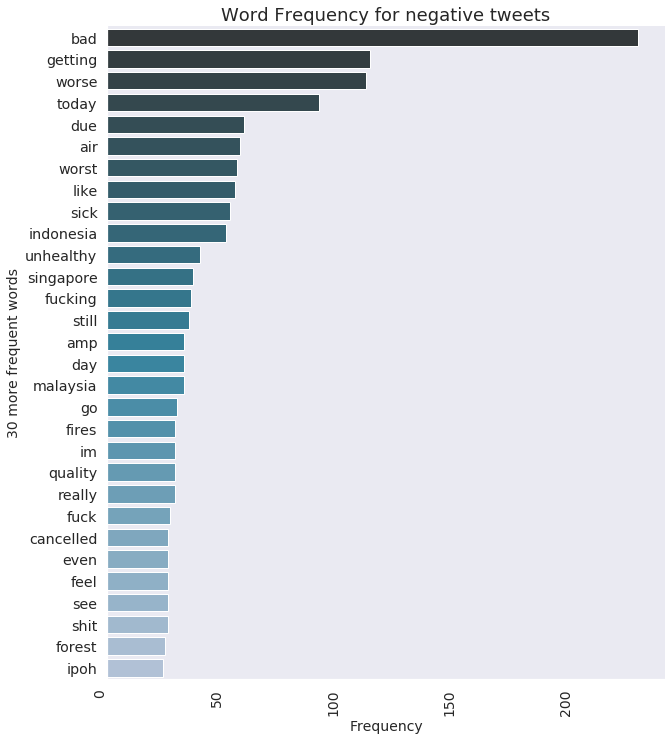

In [23]:
wf.vectorization(df_pandas[df_pandas['sentiment'] == -1], sent2="negative")

Similar to the word clouds, we can see that people are mostly expressing thier frustration about the haze and we can know which countries are affected by it.

For now, I'm still looking for solutions to handle situations like "not bad" or "not good".
"not bad" isn't a negative term and "not good" isn't a positive term, using certain NLP libraries might detect a false positive. Plus, adding features to detect sarcasm will help in increasing accuracy for text analysis.

Analysing tweets can have many use cases, especially in consumer businesses like brand monitoring, product launches insights, customer support email analysis, voice of customer(VOC) or feedback analysis.